# Aprendizagem de Máquina I

## Hugo Tremonte de Carvalho

#### hugo@dme.ufrj.br

O objetivo do exemplo é trabalhar com a base de dados MNIST ("*Modified National Institute of Standards and Technology*"). Tal base consiste de 70.000 imagens de tamanho 28 x 28, em tons de cinza, contendo dígitos manuscritos, e o principal objetivo com ela é identificar qual é o dígito em questão. Algoritmos extremamente sofisticados (e pesadíssimos!) chegam a atingir uma taxa de erro de 0,17%, mas aqui vamos trabalhar os bem mais simples *Naive Bayes* e análises de discriminante.

In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve

## A base de dados

Primeiramente, vamos carregar e fazer uma análise preliminar na base de dados.

In [3]:
# Baixando a base de dados

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=True)

c:\Users\hugom\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
# Vendo o cabeçalho referente à X, bem como seu tamanho

print(X.shape)
X.head()

(70000, 784)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Vendo o cabeçalho referente à y, bem como seu tamanho

print(y.shape)
y.head()

(70000,)


0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

Como podemos ver acima, `X` é um *dataframe* de 70.000 linhas e 784 colunas, e `y` é um *array* de tamanho 70.000, contendo o número referente a cada linha de `X`. Portanto, cada linha de `X` representa uma imagem de um dígito manuscrito. Vejamos alguns exemplos:

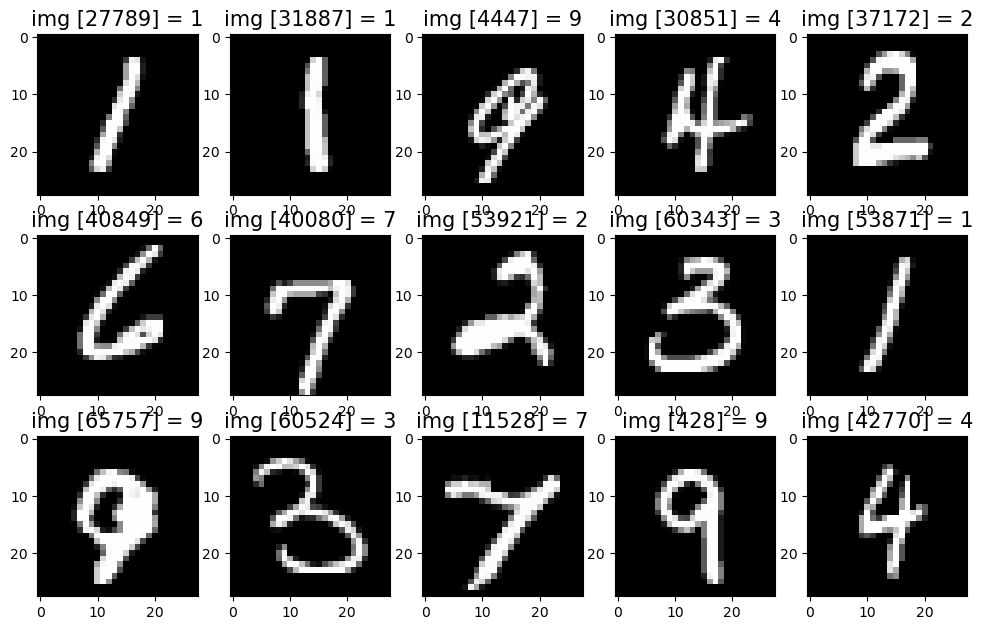

In [6]:
# FONTE: https://www.kaggle.com/code/soham1024/basic-neural-network-from-scratch-in-python

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(12, 10))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0].reshape(28, 28)        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

random_images = []
for i in range(0, 15):
    r = np.random.randint(1, 70000)
    random_images.append((X.values[r], 'img [' + str(r) + '] = ' + str(y[r])))

show_images(list(map(lambda x: x[0], random_images)), list(map(lambda x: x[1], random_images)))

Acima, nós vimos como são algumas das linhas de `X` pensadas como uma imagem de tamanho 28 x 28. Agora, vamos estudar a sua estrutura como um vetor de tamanho 784.

Dígito: 9


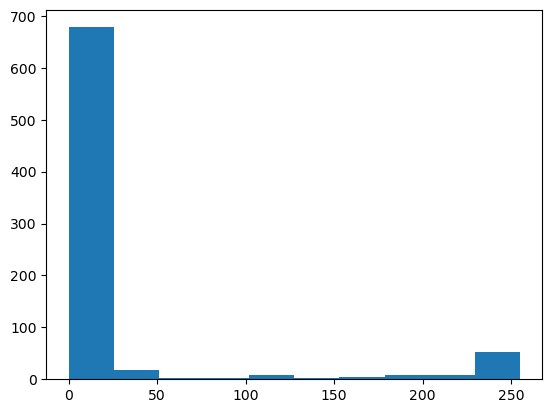

In [7]:
r = np.random.randint(1, 70000)
plt.hist(X.values[r])
print('Dígito:', y[r])
plt.show()

Agora, vejamos o histograma de um *pixel* em particular, ao longo de todas as imagens de um dígito fixado:

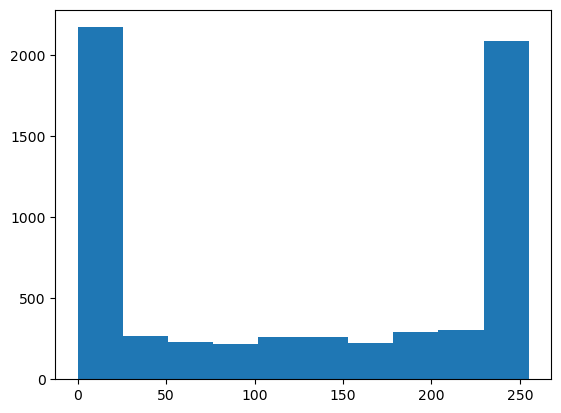

In [10]:
plt.hist(X['pixel350'][y == '5'])
plt.show()

Portanto, do ponto de vista estatístico, cada linha do *dataframe* `X` consiste de 784 observações de variáveis aleatórias que tomam seus valores entre 0 e 255 e concentram-se principalmente em torno de tais valores. Essa é exatamente a estrutura de uma imagem em tons de cinza: o valor igual a 0 representa um *pixel* totalmente preto e um valor igual a 255 representa um *pixel* totalmente branco. Recomendo rodar diversas vezes o bloco acima, para verificar como varia o histograma dos tons de cinza. Nosso objetivo será tentar identificar qual dígito está sendo representado por determinado vetor de tamanho 784 (cujas componentes chamaremos de *atributos*), utilizando o classificador *Naive Bayes*.

Para melhorar a magnitude de nossos dados, iremos fazer uma espécie de normalização, dividindo todos os valores de `X` por 255, para que tenhamos sempre valores entre 0 e 1.

In [11]:
# ATENÇÃO! Se você rodar essa célula mais de uma vez, vai estar "comprimindo" ainda mais os valores de X! Recomendo não fazer isso para evitar erros numéricos.

X = X/255

## Classificando a base

Uma prática em aprendizagem de máquina é dividir nossa base de dados em duas partes: um *conjunto de treinamento* e um *conjunto de teste*. O primeiro será usado para estimarmos os parâmetros que o classificador precisará, e o segundo será usado para medir a sua performance. O `scikit-learn` tem ferramentas que fazem essa separação de modo automático. Abaixo, deixamos 60.000 observações para treinamento e 10.000 para teste. Para garantir igual representatividade das classes em ambos os conjuntos fazemos uma *amostragem estratificada*, através do parâmetro `stratify = y`.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 10000, shuffle = True, stratify = y)

AGRADECIMENTO: Carlos Eduado Valladares da Mota (Ciência da Computação)

In [13]:
# Prepara, treina e testa nosso classificador, retornando
# O número de acertos, erros e a acurácia no teste

## AQUI PODEMOS TROCAR GaussianNB POR BernoulliNB ##
# gnb = GaussianNB()
gnb = BernoulliNB()
####################################################

gnb = gnb.fit(X_train, y_train)

predicoes_digitos = gnb.predict(X_test)
predicoes_prob_digitos = gnb.predict_proba(X_test)

predicoes_corretas = []
predicoes_erradas = []

for i in range(len(predicoes_digitos)):
  if predicoes_digitos[i] == y_test.iloc[i]:
    predicoes_corretas.append(i)

  else:
    predicoes_erradas.append(i)

qtd_pred_corretas = len(predicoes_corretas)
qtd_pred_erradas = len(predicoes_erradas)
qtd_pred_totais = qtd_pred_corretas + qtd_pred_erradas

print("Predições corretas: {0}; Predições incorretas: {1}"
      .format(str(qtd_pred_corretas), str(qtd_pred_erradas) ))

print("Taxa de acerto: {0:.2f}%".format( 100 * qtd_pred_corretas/qtd_pred_totais ))

Predições corretas: 8345; Predições incorretas: 1655
Taxa de acerto: 83.45%


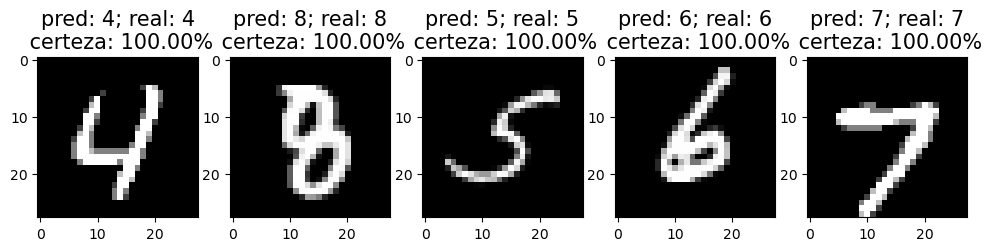

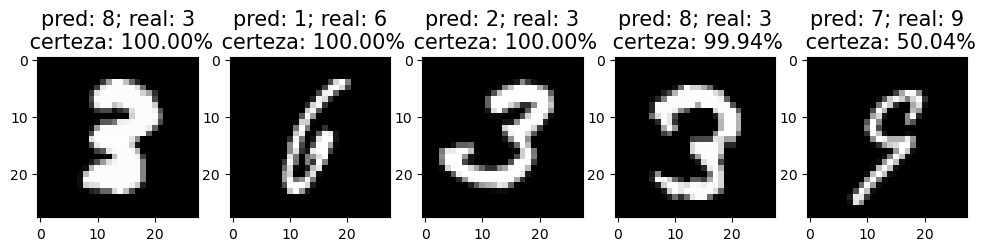

In [14]:
# Escolhe aleatoriamente as imagens, exibe o
# vetor de probabilidades informado pelo nosso
# classificador, bem como as predições e rótulos

indices_aleatorios_corretas = []
for i in range(5):
  indices_aleatorios_corretas.append( predicoes_corretas[np.random.randint(0, len(predicoes_corretas))] )

indices_aleatorios_erradas = []
for i in range(5):
  indices_aleatorios_erradas.append( predicoes_erradas[np.random.randint(0, len(predicoes_erradas))] )

imgs_corretas = []
pred_imgs_corretas = []

imgs_erradas = []
pred_imgs_erradas = []

for indice in indices_aleatorios_corretas:
  imgs_corretas.append([X_test.iloc[indice]])
  pred_imgs_corretas.append("pred: {0}; real: {1}\n certeza: {2:.2f}%".format(
    predicoes_digitos[indice], y_test.iloc[indice], 100 * predicoes_prob_digitos[indice][int(predicoes_digitos[indice])]))

for indice in indices_aleatorios_erradas:
  imgs_erradas.append([X_test.iloc[indice]])
  pred_imgs_erradas.append("pred: {0}; real: {1}\n certeza: {2:.2f}%".format(
    predicoes_digitos[indice], y_test.iloc[indice], 100 * predicoes_prob_digitos[indice][int(predicoes_digitos[indice])]))

show_images(np.array(imgs_corretas), pred_imgs_corretas) 
show_images(np.array(imgs_erradas), pred_imgs_erradas) 

In [15]:
score_train = gnb.score(X_train, y_train)
score_test = gnb.score(X_test, y_test)
print("Acurácia no treino: {0}; Acurácia no teste: {1}".format(score_train, score_test))
print("Diferença na acurácia: {0:.4f}; Inflação na acurácia: {1:.4f}%".format(score_train - score_test, 100 * (1 - (score_test/score_train))))

Acurácia no treino: 0.8321666666666667; Acurácia no teste: 0.8345
Diferença na acurácia: -0.0023; Inflação na acurácia: -0.2804%


[[ 893    1    4    5    2   38   13    0   28    2]
 [   0 1089    4    2    3   13    3    1    9    1]
 [  18   13  820   21   24    4   30   14   53    2]
 [   8   17   48  802    3   35    6   14   55   32]
 [   0    8    8    0  791    5   14    4   21  124]
 [  32   14    9  139   31  630   12    2   15   18]
 [  13   28   15    0    2   26  889    0    8    1]
 [   4   27   14    3   31    1    1  869   25   67]
 [   8   33   19   70   12   27    7    1  749   49]
 [   9   14    3   15   71    5    1   36   27  813]]


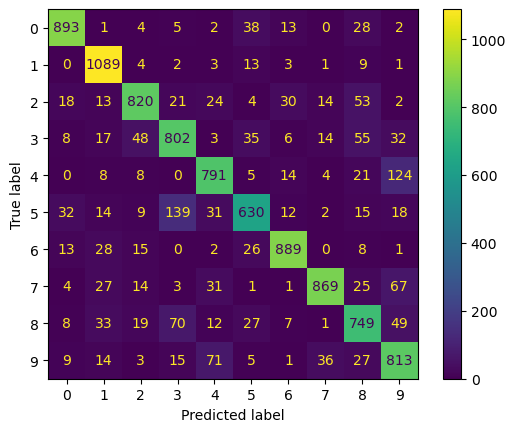

In [16]:
# A variável y_test_pred abaixo deverá ser a previsão do seu classificador no conjunto de teste, ou seja, em X_test.

labels = y.cat.categories
y_test_pred = predicoes_digitos
cm = confusion_matrix(y_test, y_test_pred, labels=labels)
print(cm)
disp = ConfusionMatrixDisplay(cm, display_labels = labels)
disp.plot()
plt.show()

## Parte 1

a) Transforme esse problema de classificação *multiclasse* em um problema de classificação *binária*. Você pode escolher o problema binário que quiser: classificar `5` ou `não 5`, classificar `par` ou `ímpar`, `primo` ou `não primo`, etc... Faça a divisão estratificada em treinamento e teste, a fim de manter a mesma proporção das classes em ambos os conjuntos.

b) Treine todos os classificadores que vimos até o momento (`GaussianNB`, `BernoulliNB`, `LDA` e `QDA`) no conjunto de treinamento. Leia a documentação dos classificadores para entender como eles funcionam.

c) Faça modificações adequadas nos códigos abaixo para calcular todas as métricas baseadas na matriz de confusão que vimos em aula.

In [ ]:
CM = confusion_matrix(y_test, .....)

Pop = np.size(y_test)
N = np.size(np.where(y_test == .....))
P = np.size(np.where(y_test == .....))

VN = CM[0, 0]
FP = CM[0, 1]
FN = CM[1, 0]
VP = CM[1, 1]

Prev = P/Pop
Acc = (VN + VP)/Pop

FPR = FP/N
TNR = VN/N
TPR = VP/P
FNR = FN/P

FOR = FN/(VN + FN)
PPV = VP/(FP + VP)
NPV = VN/(VN + FN)
FDR = FP/(FP + VP)

F1 = 2/(1/PPV + 1/TPR)

In [ ]:
print('Prevalência:', Prev)
print('Acurácia:', Acc)

print('Taxa de falsos positivos:', FPR)
print('Taxa de verdadeiros negativos (Especificidade):', TNR)
print('Taxa de verdadeiros positivos (Recall):', TPR)
print('Taxa de falsos negativos:', FNR)

print('False omission rate:', FOR)
print('Valor preditivo positivo (Precisão):', PPV)
print('Valor preditivo negativo:', NPV)
print('False discovery rate:', FDR)

print('F1 Score:', F1)

## Parte 2

d) Para todos os classificadores que você treinou, calcule as métricas referentes à curva ROC.

e) Modifique o código abaixo para alterar a probabilidade de corte de $0,\!5$ para algum valor $p_0$ qualquer. Calcule as métricas baseadas na matriz de confusão para esse novo cenário.

In [ ]:
y_test_pred_proba = gnb.predict_proba(X_test)

p0 = 0.28

y_test_pred_p0 = 1*(y_test_pred_proba[:,1] > p0)